<a href="https://colab.research.google.com/github/KaranKendre11/pytorch-learning/blob/main/CNN_mnist_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
# Convert MNIST Image files into a Tensor of 4-Dimensions( # of images, height, width, color channels)
transform = transforms.ToTensor()

In [4]:
# Train data
train_data = datasets.MNIST(root='cnn_data', train=True, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]


Extracting cnn_data/MNIST/raw/train-images-idx3-ubyte.gz to cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 491kB/s]


Extracting cnn_data/MNIST/raw/train-labels-idx1-ubyte.gz to cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]


Extracting cnn_data/MNIST/raw/t10k-images-idx3-ubyte.gz to cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.81MB/s]

Extracting cnn_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to cnn_data/MNIST/raw



In [5]:
# Test data
test_data = datasets.MNIST(root='cnn_data', train=False, download=True, transform=transform)

In [6]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [8]:
# Create a small batch size for images... let's say 10
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [9]:
# Define our CNN Model
# Describe convolutional layer and what it's doing (2 convolutional layers)
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

In [10]:
# Grab 1 MNIST image
for i, (X_train, y_train) in enumerate(train_data):
  break

In [11]:
X_train.shape

torch.Size([1, 28, 28])

In [12]:
x = X_train.view(1, 1, 28, 28)

In [13]:
# Perform our first convolution
x = F.relu(conv1(x)) # Rectified Linear Unit for our activation function

In [15]:
# 1 single image, 6 filters, 26x26 (kernal size was 3x3 and stride was 1)
x.shape

torch.Size([1, 6, 26, 26])

In [16]:
# pass thru the pooling layer
x = F.max_pool2d(x, 2, 2) # kerner of 2 and stride of 2


In [17]:
x.shape # 26 / 2 = 13

torch.Size([1, 6, 13, 13])

In [18]:
# Do our second convolutional layer
x = F.relu(conv2(x))

In [19]:
x.shape # again, we didnt set padding so we lose 2 pixels

torch.Size([1, 16, 11, 11])

In [20]:
x = F.max_pool2d(x, 2, 2)

In [22]:
x.shape # 11 / 2 = 5.5

torch.Size([1, 16, 5, 5])

In [25]:
# MODEL CLASS
class CNNModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 3, 1)
    self.conv2 = nn.Conv2d(6, 16, 3, 1)
    # Fully connected layers
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, X):
    # First pass
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2)
    # Second Pass
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2)
    # Re-view to flatten it out
    X = X.view(-1, 16*5*5) # negative one so that we can vary batch size
    # Fully connected layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim=1)


In [26]:
# Create an Instance of our model
torch.manual_seed(41)
model = CNNModel()
model

CNNModel(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [28]:
# Loss function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [30]:
import time
start_time = time.time()

# Create variables to track things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For loop of epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0

  # Train
  for b, (X_train, y_train) in enumerate(train_loader):
    b  += 1 # start our batches at 1
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    predicted = torch.max(y_pred.data, 1)[1] # add up the number of correct predictions.
    # Indexed off the first point
    batch_corr = (predicted == y_train).sum() # how many we got corrected from this batch.
    # True = 1, # False = 0
    trn_corr += batch_corr # keep track as we go along in training.

    # Update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print out some results
    if b%600 == 0:
      print(f'Epoch: {i}, Batch: {b}, Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)

  # Test
  with torch.no_grad(): # No gradient so we don't update our weights and biases with test data
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1] # Adding up correct predictions
      tst_corr += (predicted == y_test).sum() # T=1 F=0 and sum away

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)

current_time = time.time()
total = current_time - start_time
print(f'Training Took: {total/60} minutes!')

Epoch: 0, Batch: 600, Loss: 0.1623610556125641
Epoch: 0, Batch: 1200, Loss: 0.1502392590045929
Epoch: 0, Batch: 1800, Loss: 0.4744560718536377
Epoch: 0, Batch: 2400, Loss: 0.14238706231117249
Epoch: 0, Batch: 3000, Loss: 0.007758188061416149
Epoch: 0, Batch: 3600, Loss: 0.3836284875869751
Epoch: 0, Batch: 4200, Loss: 0.0038223876617848873
Epoch: 0, Batch: 4800, Loss: 0.0021286322735249996
Epoch: 0, Batch: 5400, Loss: 0.0569545142352581
Epoch: 0, Batch: 6000, Loss: 0.00038789428072050214
Epoch: 1, Batch: 600, Loss: 0.005851339548826218
Epoch: 1, Batch: 1200, Loss: 0.3855525553226471
Epoch: 1, Batch: 1800, Loss: 0.004819948226213455
Epoch: 1, Batch: 2400, Loss: 0.003216963727027178
Epoch: 1, Batch: 3000, Loss: 0.0332382395863533
Epoch: 1, Batch: 3600, Loss: 0.5372857451438904
Epoch: 1, Batch: 4200, Loss: 0.04561494290828705
Epoch: 1, Batch: 4800, Loss: 0.0007510822033509612
Epoch: 1, Batch: 5400, Loss: 0.0001173773780465126
Epoch: 1, Batch: 6000, Loss: 0.14201366901397705
Epoch: 2, Batch

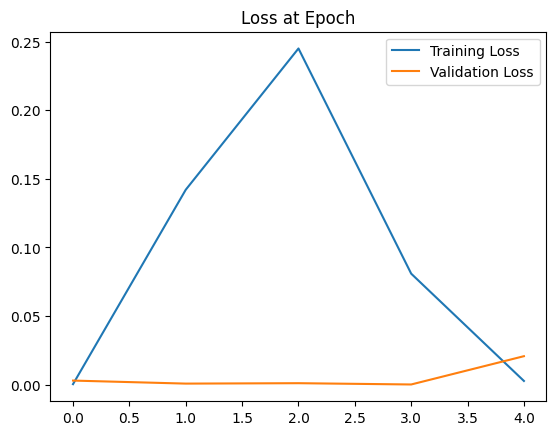

In [33]:
# Graph the loss at epoch
# train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss at Epoch")
plt.legend()

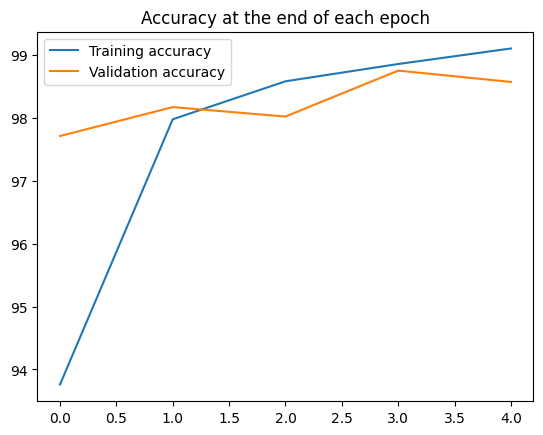

In [37]:
# graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label="Training accuracy")
plt.plot([t/100 for t in test_correct], label="Validation accuracy")
plt.title("Accuracy at the end of each epoch")
plt.legend()

In [38]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [39]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()

In [41]:
# Did for correct
correct.item()/len(test_data) * 100

98.57000000000001

In [42]:
# Grab an image
test_data[4143] # tensor with an image in it... at end, it shows the label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [43]:
# Grab just the data
test_data[4143][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [44]:
# Reshape it
test_data[4143][0].reshape(28, 28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

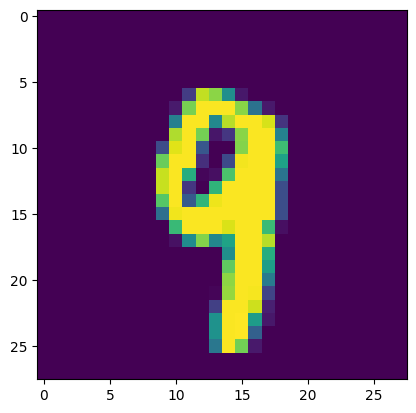

In [49]:
# show the image
plt.imshow(test_data[4143][0].reshape(28, 28))

In [50]:
# Pass the image through our model
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[4143][0].view(1, 1, 28, 28)) # batch size of 1, 1 color channel, 28x28 image

In [51]:
# Check the new prediction.... get probabilities

In [52]:
new_prediction

tensor([[-2.1693e+01, -1.8584e+01, -2.1709e+01, -1.5842e+01, -8.6330e+00,
         -1.8415e+01, -3.1769e+01, -1.2734e+01, -1.3396e+01, -1.8273e-04]])

In [53]:
new_prediction.argmax()

tensor(9)